In [ ]:
!pip install scikit-surprise xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 5.2 MB/s eta 0:00:00
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357286 sha256=b2c46d7e45cb5c55ebfd9476f0b725eaf77fd990116abd63956deb8e754442d3
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


Computing the cosine similarity matrix...
Done computing similarity matrix.
User-Based CF - RMSE: 1.0193536815834319, MAE: 0.8037993357440609
SVD - RMSE: 0.9348686211216123, MAE: 0.7366703694917878
K-Means - RMSE: 0.9396304955919259, MAE: 0.7375096031495175
XGBoost - RMSE: 1.021865486343048, MAE: 0.8173636813104153


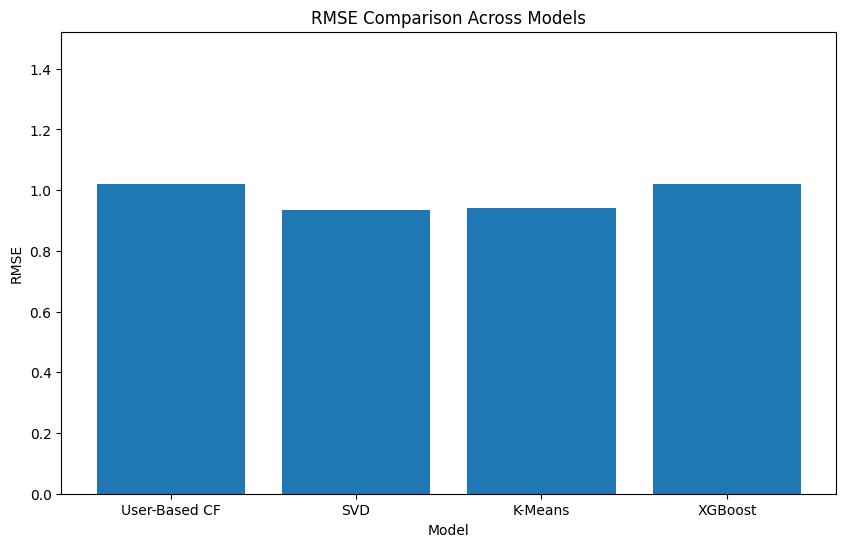

In [ ]:
# Install necessary libraries in Google Colab
# Uncomment the next line if libraries are not already installed
# !pip install scikit-surprise xgboost

# Import libraries
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from surprise import Dataset, Reader, SVD, KNNBasic
from surprise.model_selection import train_test_split as surprise_train_test_split
from sklearn.model_selection import train_test_split as sklearn_train_test_split
from sklearn.cluster import KMeans
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load dataset
u_data_path = "/content/u.data"
u_item_path = "/content/u.item"

u_data_columns = ["user_id", "item_id", "rating", "timestamp"]
u_data = pd.read_csv(u_data_path, sep="\t", names=u_data_columns, header=None)

u_item_columns = [
    "item_id", "title", "release_date", "video_release_date",
    "IMDb_url", "unknown", "Action", "Adventure", "Animation",
    "Children", "Comedy", "Crime", "Documentary", "Drama", "Fantasy",
    "Film-Noir", "Horror", "Musical", "Mystery", "Romance",
    "Sci-Fi", "Thriller", "War", "Western"
]
u_item = pd.read_csv(u_item_path, sep="|", names=u_item_columns, header=None, encoding='latin-1')

# Step 1: Memory-Based Collaborative Filtering (User-Based CF)
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(u_data[['user_id', 'item_id', 'rating']], reader)
trainset, testset = surprise_train_test_split(data, test_size=0.2, random_state=42)

sim_options = {'name': 'cosine', 'user_based': True}
user_based_model = KNNBasic(sim_options=sim_options)
user_based_model.fit(trainset)
predictions_user_cf = user_based_model.test(testset)

# Evaluation for User-Based CF
rmse_user_cf = np.sqrt(mean_squared_error([pred.r_ui for pred in predictions_user_cf],
                                          [pred.est for pred in predictions_user_cf]))
mae_user_cf = mean_absolute_error([pred.r_ui for pred in predictions_user_cf],
                                   [pred.est for pred in predictions_user_cf])
print(f"User-Based CF - RMSE: {rmse_user_cf}, MAE: {mae_user_cf}")

# Step 2: Model-Based Collaborative Filtering with SVD
svd_model = SVD()
svd_model.fit(trainset)
predictions_svd = svd_model.test(testset)

# Evaluation for SVD
rmse_svd = np.sqrt(mean_squared_error([pred.r_ui for pred in predictions_svd],
                                      [pred.est for pred in predictions_svd]))
mae_svd = mean_absolute_error([pred.r_ui for pred in predictions_svd],
                               [pred.est for pred in predictions_svd])
print(f"SVD - RMSE: {rmse_svd}, MAE: {mae_svd}")

# Step 3: Model-Based Collaborative Filtering with K-Means
user_item_matrix = u_data.pivot(index='user_id', columns='item_id', values='rating').fillna(0)
kmeans = KMeans(n_clusters=10, random_state=42)
user_clusters = kmeans.fit_predict(user_item_matrix)

# Create a mapping from user_id to cluster
user_id_to_cluster = {user_id: cluster for user_id, cluster in zip(user_item_matrix.index, user_clusters)}

def predict_kmeans(row):
    cluster = user_id_to_cluster.get(row['user_id'], None)
    if cluster is None:
        return 0  # Default prediction for missing cluster
    cluster_data = u_data[u_data['cluster'] == cluster]
    cluster_avg = cluster_data.groupby('item_id')['rating'].mean()
    return cluster_avg.get(row['item_id'], 0)  # Default to 0 if item is not in cluster

# Predict ratings using K-Means
u_data['cluster'] = [user_clusters[u - 1] for u in u_data['user_id']]
testset_df = pd.DataFrame(testset, columns=["user_id", "item_id", "rating"])
testset_df['predicted'] = testset_df.apply(predict_kmeans, axis=1)

rmse_kmeans = np.sqrt(mean_squared_error(testset_df['rating'], testset_df['predicted']))
mae_kmeans = mean_absolute_error(testset_df['rating'], testset_df['predicted'])
print(f"K-Means - RMSE: {rmse_kmeans}, MAE: {mae_kmeans}")

# Step 4: Model-Based Collaborative Filtering with XGBoost
u_data_encoded = u_data.copy()
label_encoders = {}
for col in ['user_id', 'item_id']:
    le = LabelEncoder()
    u_data_encoded[col] = le.fit_transform(u_data_encoded[col])
    label_encoders[col] = le

X = u_data_encoded[['user_id', 'item_id']]
y = u_data_encoded['rating']
X_train, X_test, y_train, y_test = sklearn_train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred))
mae_xgb = mean_absolute_error(y_test, y_pred)
print(f"XGBoost - RMSE: {rmse_xgb}, MAE: {mae_xgb}")

# Visualization for RMSE
models = ['User-Based CF', 'SVD', 'K-Means', 'XGBoost']
rmse_values = [rmse_user_cf, rmse_svd, rmse_kmeans, rmse_xgb]

plt.figure(figsize=(10, 6))
plt.bar(models, rmse_values)
plt.title('RMSE Comparison Across Models')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.ylim(0, max(rmse_values) + 0.5)
plt.show()


<ipython-input-7-e4e45ff9c948>:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_predictions = testset_df.groupby('user_id').apply(
<ipython-input-7-e4e45ff9c948>:41: RuntimeWarning: invalid value encountered in scalar divide
  recall = top_k.sum() / relevant.sum()
<ipython-input-7-e4e45ff9c948>:41: RuntimeWarning: divide by zero encountered in scalar divide
  recall = top_k.sum() / relevant.sum()
<ipython-input-7-e4e45ff9c948>:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or exp

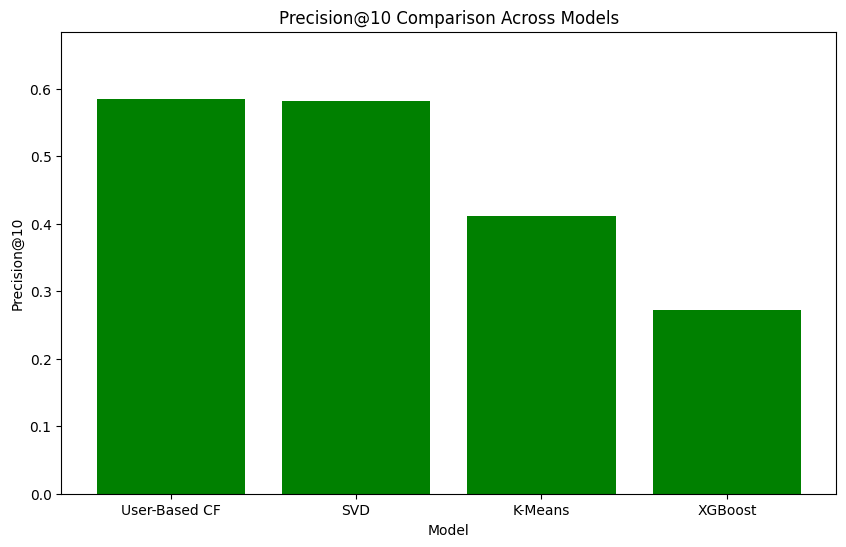

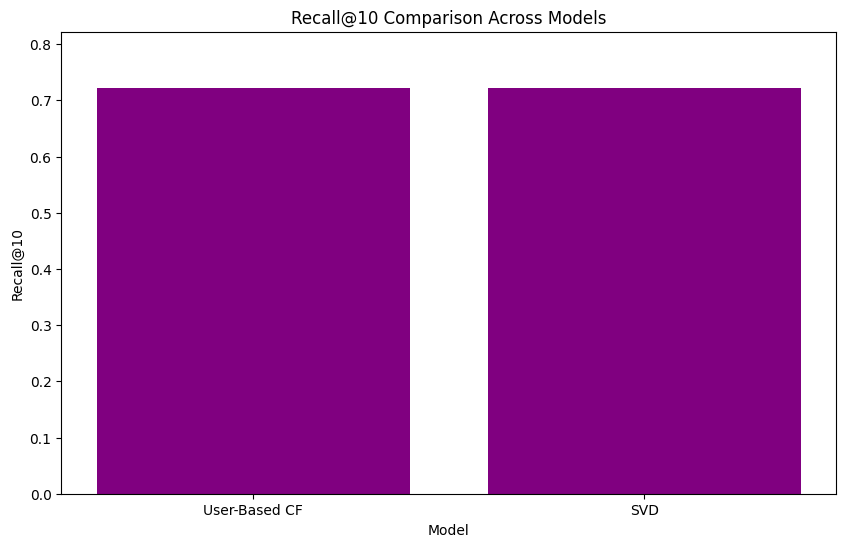

In [ ]:
# Define Precision@k and Recall@k Calculation Function
def precision_recall_at_k(predictions, k=10, threshold=4.0):
    user_predictions = {}
    for pred in predictions:
        if pred.uid not in user_predictions:
            user_predictions[pred.uid] = []
        user_predictions[pred.uid].append((pred.iid, pred.est, pred.r_ui >= threshold))

    precisions, recalls = [], []
    for uid, user_preds in user_predictions.items():
        user_preds.sort(key=lambda x: x[1], reverse=True)
        top_k = user_preds[:k]
        relevant_top_k = sum((1 for _, _, is_relevant in top_k if is_relevant))
        relevant_total = sum((1 for _, _, is_relevant in user_preds if is_relevant))

        precision = relevant_top_k / k
        recall = relevant_top_k / (relevant_total + 1e-8)  # Avoid division by zero
        precisions.append(precision)
        recalls.append(recall)

    return np.mean(precisions), np.mean(recalls)

# Compute Precision@10 and Recall@10 for User-Based CF
precision_user_cf, recall_user_cf = precision_recall_at_k(predictions_user_cf)

# Compute Precision@10 and Recall@10 for SVD
precision_svd, recall_svd = precision_recall_at_k(predictions_svd)

# Compute Precision@10 and Recall@10 for K-Means
def precision_recall_kmeans(testset_df, k=10, threshold=4.0):
    # Group by user and sort by predicted rating
    user_predictions = testset_df.groupby('user_id').apply(
        lambda group: group.sort_values('predicted', ascending=False).head(k)
    )

    precisions, recalls = [], []
    for user_id, group in user_predictions.groupby(level=0):
        top_k = group['predicted'] >= threshold
        relevant = group['rating'] >= threshold
        precision = top_k.sum() / k
        recall = top_k.sum() / relevant.sum()
        precisions.append(precision)
        recalls.append(recall)

    return np.mean(precisions), np.mean(recalls)

precision_kmeans, recall_kmeans = precision_recall_kmeans(testset_df)

# Compute Precision@10 and Recall@10 for XGBoost
def precision_recall_xgboost(X_test, y_test, y_pred, k=10, threshold=4.0):
    test_df = pd.DataFrame({'user_id': X_test['user_id'], 'item_id': X_test['item_id'],
                            'true_rating': y_test, 'predicted': y_pred})
    user_predictions = test_df.groupby('user_id').apply(
        lambda group: group.sort_values('predicted', ascending=False).head(k)
    )

    precisions, recalls = [], []
    for user_id, group in user_predictions.groupby(level=0):
        top_k = group['predicted'] >= threshold
        relevant = group['true_rating'] >= threshold
        precision = top_k.sum() / k
        recall = top_k.sum() / relevant.sum()
        precisions.append(precision)
        recalls.append(recall)

    return np.mean(precisions), np.mean(recalls)

precision_xgb, recall_xgb = precision_recall_xgboost(X_test, y_test, y_pred)

# Visualization for All Metrics
precision_values = [precision_user_cf, precision_svd, precision_kmeans, precision_xgb]
recall_values = [recall_user_cf, recall_svd, recall_kmeans, recall_xgb]

# Bar Chart for Precision@10
plt.figure(figsize=(10, 6))
plt.bar(models, precision_values, color='green')
plt.title('Precision@10 Comparison Across Models')
plt.xlabel('Model')
plt.ylabel('Precision@10')
plt.ylim(0, max(precision_values) + 0.1)
plt.show()

# Bar Chart for Recall@10
plt.figure(figsize=(10, 6))
plt.bar(models, recall_values, color='purple')
plt.title('Recall@10 Comparison Across Models')
plt.xlabel('Model')
plt.ylabel('Recall@10')
plt.ylim(0, max(recall_values) + 0.1)
plt.show()


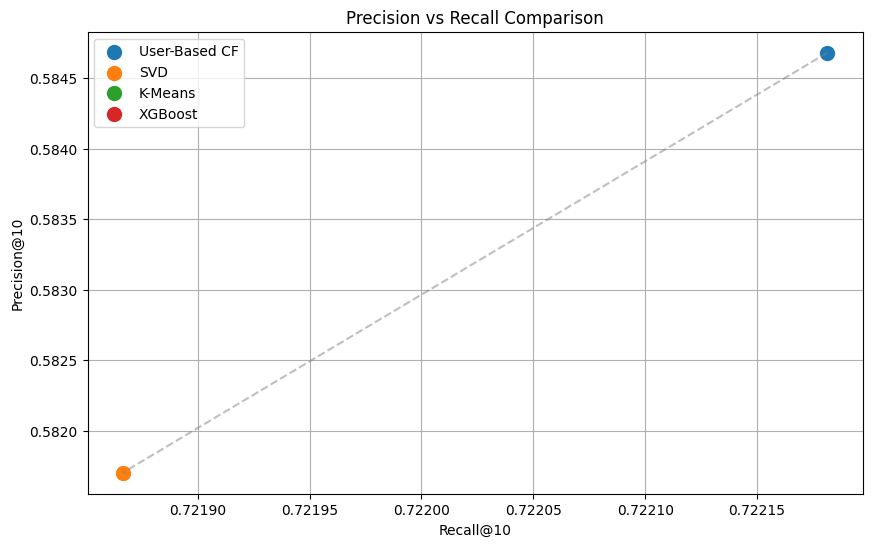

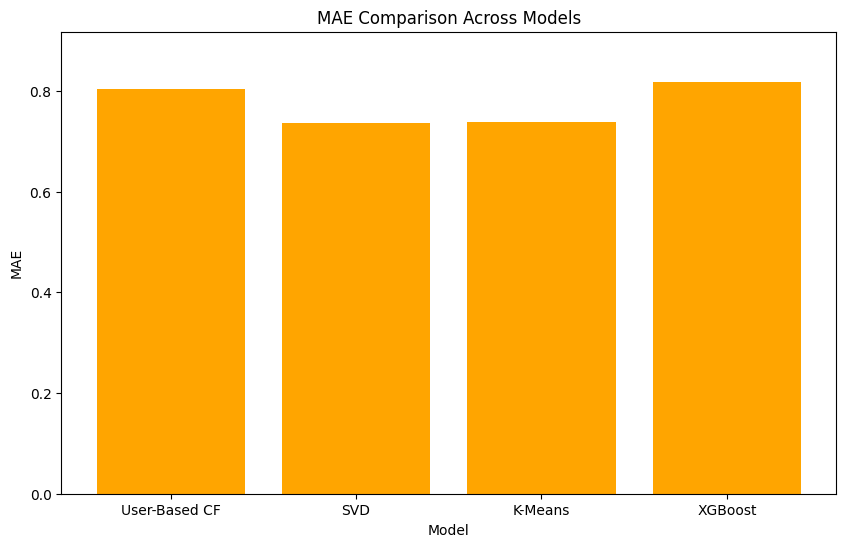

In [ ]:
# Precision vs Recall Plot
plt.figure(figsize=(10, 6))
for model, precision, recall in zip(models, precision_values, recall_values):
    plt.scatter(recall, precision, label=model, s=100)  # Scatter plot with size adjustment
plt.plot(recall_values, precision_values, linestyle='--', color='gray', alpha=0.5)  # Line connecting points
plt.title('Precision vs Recall Comparison')
plt.xlabel('Recall@10')
plt.ylabel('Precision@10')
plt.legend()
plt.grid()
plt.show()

# MAE Comparison Bar Chart
plt.figure(figsize=(10, 6))
plt.bar(models, mae_values, color='orange')
plt.title('MAE Comparison Across Models')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.ylim(0, max(mae_values) + 0.1)
plt.show()


User-Based CF - Precision@10: 0.5847, Recall@10: 0.7222
SVD - Precision@10: 0.5817, Recall@10: 0.7219
K-Means - Precision@10: 0.4114, Recall@10: nan
XGBoost - Precision@10: 0.2729, Recall@10: nan


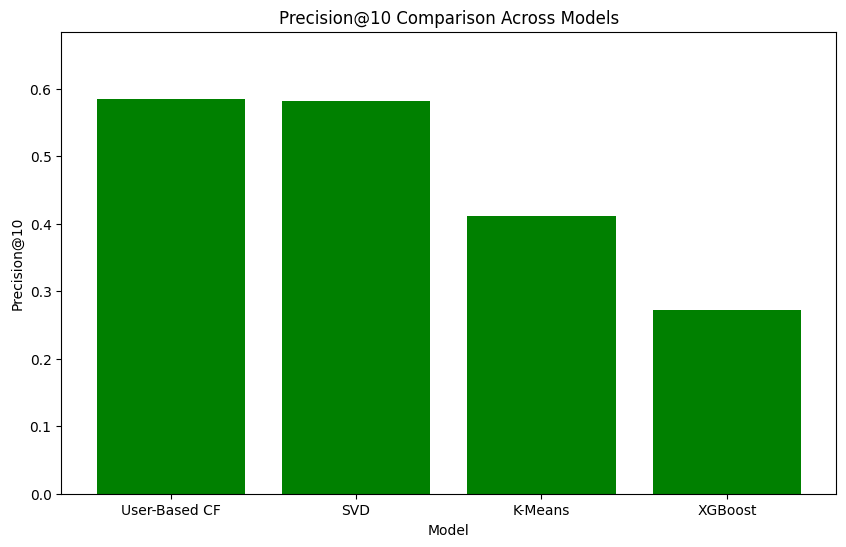

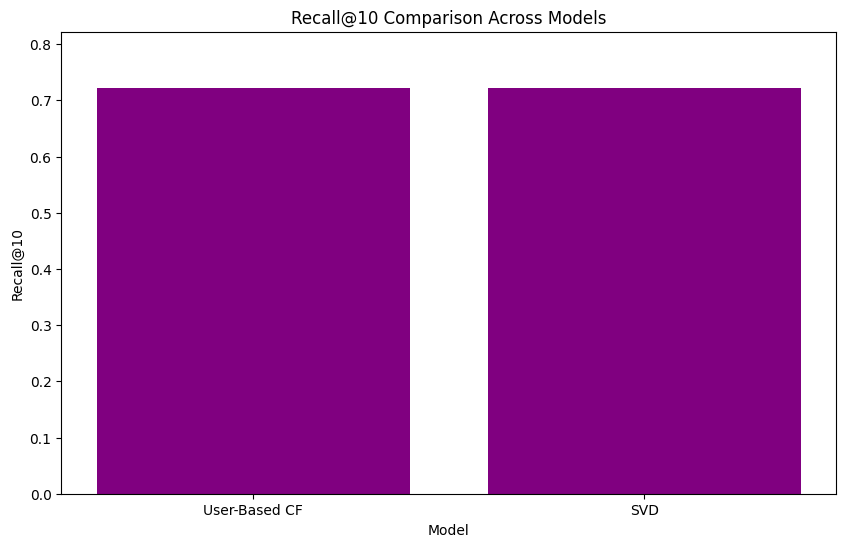

In [ ]:
# Print Precision and Recall for each model
print(f"User-Based CF - Precision@10: {precision_user_cf:.4f}, Recall@10: {recall_user_cf:.4f}")
print(f"SVD - Precision@10: {precision_svd:.4f}, Recall@10: {recall_svd:.4f}")
print(f"K-Means - Precision@10: {precision_kmeans:.4f}, Recall@10: {recall_kmeans:.4f}")
print(f"XGBoost - Precision@10: {precision_xgb:.4f}, Recall@10: {recall_xgb:.4f}")

# Visualization for Precision@10
plt.figure(figsize=(10, 6))
plt.bar(models, precision_values, color='green')
plt.title('Precision@10 Comparison Across Models')
plt.xlabel('Model')
plt.ylabel('Precision@10')
plt.ylim(0, max(precision_values) + 0.1)
plt.show()

# Visualization for Recall@10
plt.figure(figsize=(10, 6))
plt.bar(models, recall_values, color='purple')
plt.title('Recall@10 Comparison Across Models')
plt.xlabel('Model')
plt.ylabel('Recall@10')
plt.ylim(0, max(recall_values) + 0.1)
plt.show()


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute the similarity matrix for user-item matrix
similarity_matrix = cosine_similarity(user_item_matrix)

# Convert to DataFrame for better readability (optional)
similarity_df = pd.DataFrame(similarity_matrix,
                             index=user_item_matrix.index,
                             columns=user_item_matrix.index)

# Display the similarity matrix
print("User-User Similarity Matrix:")
print(similarity_df)


User-User Similarity Matrix:
user_id       1         2         3         4         5         6         7    \
user_id                                                                         
1        1.000000  0.166931  0.047460  0.064358  0.378475  0.430239  0.440367   
2        0.166931  1.000000  0.110591  0.178121  0.072979  0.245843  0.107328   
3        0.047460  0.110591  1.000000  0.344151  0.021245  0.072415  0.066137   
4        0.064358  0.178121  0.344151  1.000000  0.031804  0.068044  0.091230   
5        0.378475  0.072979  0.021245  0.031804  1.000000  0.237286  0.373600   
...           ...       ...       ...       ...       ...       ...       ...   
939      0.118095  0.228583  0.026271  0.030138  0.071459  0.111852  0.107027   
940      0.314072  0.226790  0.161890  0.196858  0.239955  0.352449  0.329925   
941      0.148617  0.161485  0.101243  0.152041  0.139595  0.144446  0.059993   
942      0.179508  0.172268  0.133416  0.170086  0.152497  0.317328  0.282003   

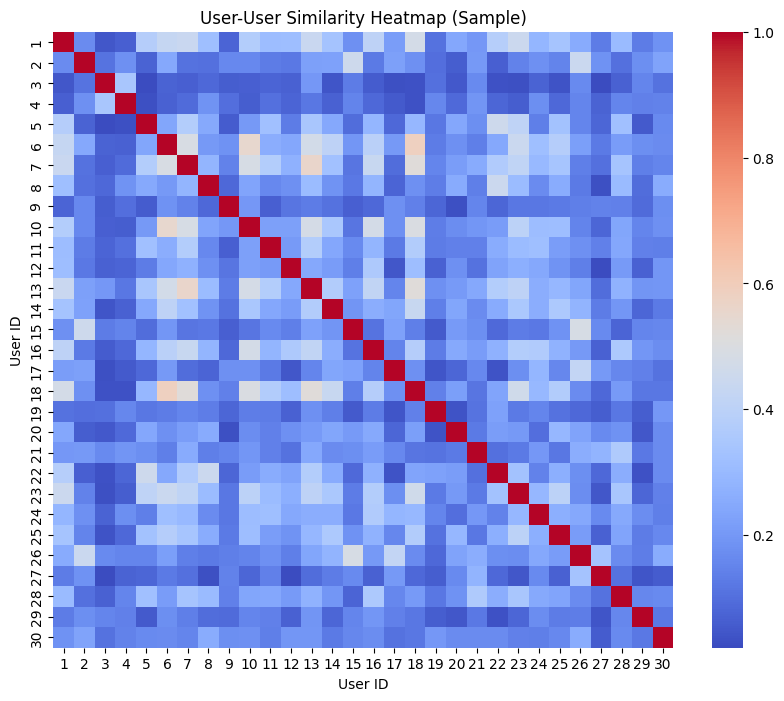

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot heatmap of user-user similarity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df.iloc[:30, :30], cmap='coolwarm', annot=False)
plt.title('User-User Similarity Heatmap (Sample)')
plt.xlabel('User ID')
plt.ylabel('User ID')
plt.show()


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Use KMeans to cluster users based on the similarity matrix
n_clusters = 5  # Set initial number of clusters (can be optimized)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
user_clusters = kmeans.fit_predict(similarity_matrix)

# Add cluster labels to a DataFrame for analysis
user_cluster_df = pd.DataFrame({'user_id': user_item_matrix.index, 'cluster': user_clusters})

# Print cluster assignments
print("User Clusters:")
print(user_cluster_df.head())

# Evaluate clustering with silhouette score
silhouette_avg = silhouette_score(similarity_matrix, user_clusters)
print(f"Silhouette Score for {n_clusters} clusters: {silhouette_avg}")


User Clusters:
   user_id  cluster
0        1        4
1        2        1
2        3        2
3        4        2
4        5        0
Silhouette Score for 5 clusters: 0.22645876162832645


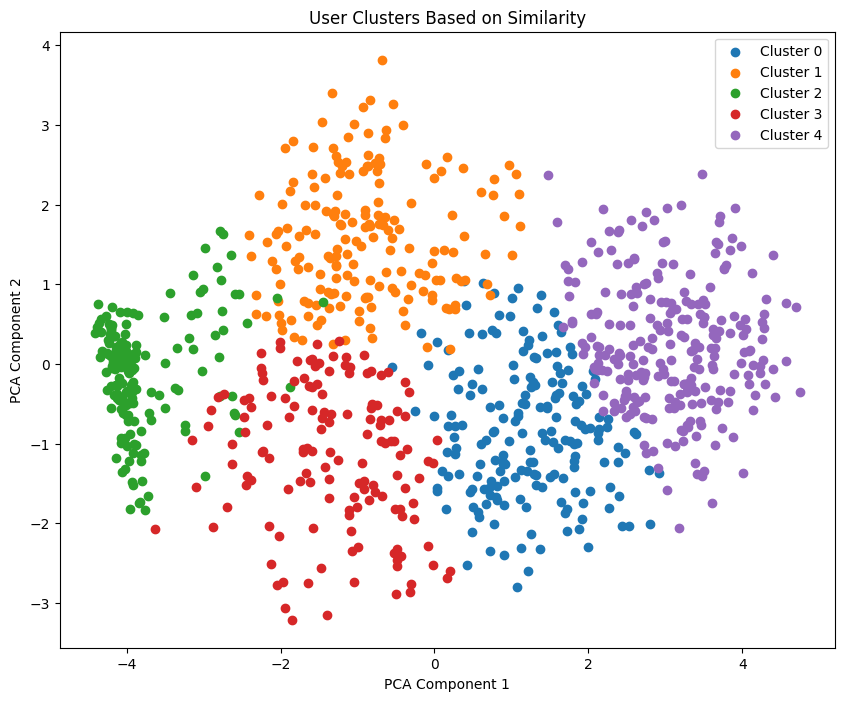

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Reduce dimensionality using PCA for visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_similarity = pca.fit_transform(similarity_matrix)

# Plot clusters
plt.figure(figsize=(10, 8))
for cluster in range(n_clusters):
    cluster_points = reduced_similarity[user_clusters == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')
plt.title('User Clusters Based on Similarity')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()


In [ ]:
# Compute average similarity for each user
average_similarity = similarity_matrix.mean(axis=1)

# Threshold for outlier detection (e.g., bottom 5%)
threshold = np.percentile(average_similarity, 5)
outliers = user_item_matrix.index[average_similarity < threshold]

print("Outliers (Users with low similarity):")
print(outliers)


Outliers (Users with low similarity):
Index([ 31,  34,  36,  50,  88,  98, 122, 167, 172, 208, 219, 242, 260, 300,
       341, 355, 358, 366, 375, 427, 440, 469, 471, 477, 519, 565, 571, 585,
       604, 656, 662, 675, 681, 685, 688, 726, 762, 813, 814, 822, 845, 855,
       859, 861, 866, 909, 914, 925],
      dtype='int64', name='user_id')


In [ ]:
# Analyze top movies in each cluster
for cluster in range(n_clusters):
    cluster_users = user_cluster_df[user_cluster_df['cluster'] == cluster]['user_id']
    cluster_data = u_data[u_data['user_id'].isin(cluster_users)]
    top_movies = cluster_data['item_id'].value_counts().head(5)
    print(f"Cluster {cluster} - Top Movies:")
    print(top_movies)


Cluster 0 - Top Movies:
item_id
50     143
174    134
56     120
98     116
100    107
Name: count, dtype: int64
Cluster 1 - Top Movies:
item_id
1      138
100    136
50     134
117    134
121    133
Name: count, dtype: int64
Cluster 2 - Top Movies:
item_id
300    137
286    130
288    122
258    121
313    114
Name: count, dtype: int64
Cluster 3 - Top Movies:
item_id
286    66
100    54
288    50
258    49
127    46
Name: count, dtype: int64
Cluster 4 - Top Movies:
item_id
50     247
174    245
181    239
172    233
204    229
Name: count, dtype: int64


In [ ]:
# Analyze ratings from outliers
outlier_data = u_data[u_data['user_id'].isin(outliers)]
print("Ratings from Outlier Users:")
print(outlier_data.head())


Ratings from Outlier Users:
    user_id  item_id  rating  timestamp  cluster
16      122      387       5  879270459        8
21      167      486       4  892738452        8
30       50      246       3  877052329        5
46      242     1137       5  879741196        5
52      260      322       4  890618898        5


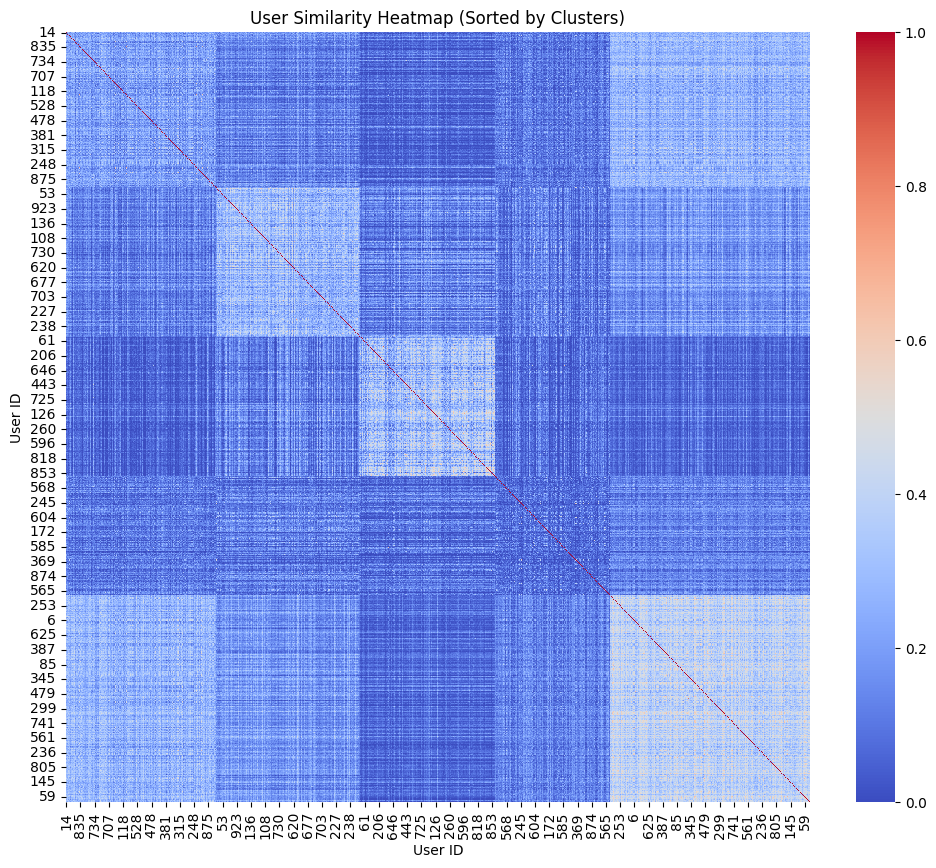

In [ ]:
# Sort similarity matrix by cluster
sorted_indices = user_cluster_df.sort_values('cluster')['user_id']
sorted_similarity_matrix = similarity_df.loc[sorted_indices, sorted_indices]

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(sorted_similarity_matrix, cmap='coolwarm', annot=False)
plt.title('User Similarity Heatmap (Sorted by Clusters)')
plt.xlabel('User ID')
plt.ylabel('User ID')
plt.show()


In [ ]:
# Map item_id to movie titles
movie_mapping = u_item.set_index('item_id')['title'].to_dict()

for cluster in range(n_clusters):
    cluster_users = user_cluster_df[user_cluster_df['cluster'] == cluster]['user_id']
    cluster_data = u_data[u_data['user_id'].isin(cluster_users)]
    top_movies = cluster_data['item_id'].value_counts().head(5).index.map(movie_mapping)
    print(f"Cluster {cluster} - Top Movies:")
    print(list(top_movies))


Cluster 0 - Top Movies:
['Star Wars (1977)', 'Raiders of the Lost Ark (1981)', 'Pulp Fiction (1994)', 'Silence of the Lambs, The (1991)', 'Fargo (1996)']
Cluster 1 - Top Movies:
['Toy Story (1995)', 'Fargo (1996)', 'Star Wars (1977)', 'Rock, The (1996)', 'Independence Day (ID4) (1996)']
Cluster 2 - Top Movies:
['Air Force One (1997)', 'English Patient, The (1996)', 'Scream (1996)', 'Contact (1997)', 'Titanic (1997)']
Cluster 3 - Top Movies:
['English Patient, The (1996)', 'Fargo (1996)', 'Scream (1996)', 'Contact (1997)', 'Godfather, The (1972)']
Cluster 4 - Top Movies:
['Star Wars (1977)', 'Raiders of the Lost Ark (1981)', 'Return of the Jedi (1983)', 'Empire Strikes Back, The (1980)', 'Back to the Future (1985)']


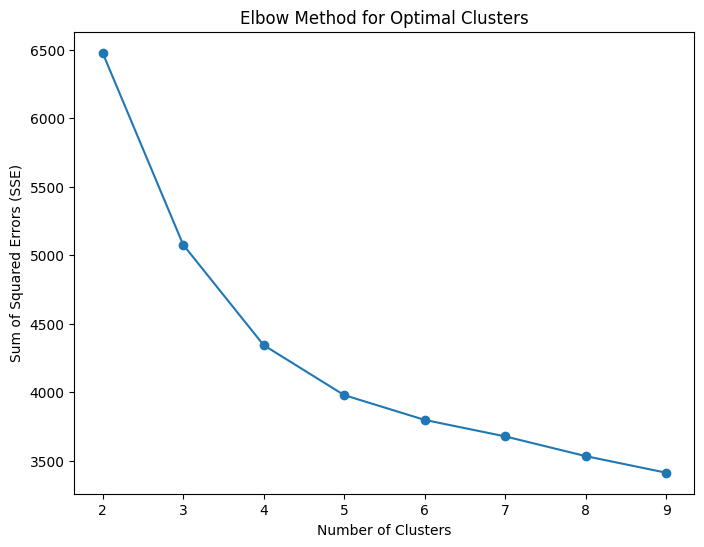

In [ ]:
# Elbow Method for Optimal Clusters
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

sse = []
for k in range(2, 10):  # Experiment with different cluster numbers
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(similarity_matrix)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(2, 10), sse, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.show()


In [ ]:
# Re-run KMeans with 4 clusters
n_clusters_optimal = 4
kmeans_optimal = KMeans(n_clusters=n_clusters_optimal, random_state=42)
user_clusters_optimal = kmeans_optimal.fit_predict(similarity_matrix)

# Evaluate new clustering
silhouette_optimal = silhouette_score(similarity_matrix, user_clusters_optimal)
print(f"Silhouette Score for {n_clusters_optimal} clusters: {silhouette_optimal}")

# Visualize the new clusters
user_cluster_df_optimal = pd.DataFrame({'user_id': user_item_matrix.index, 'cluster': user_clusters_optimal})


Silhouette Score for 4 clusters: 0.280827264128756


In [ ]:
# Recommend top movies to a specific cluster
cluster_to_recommend = 2
cluster_users = user_cluster_df[user_cluster_df['cluster'] == cluster_to_recommend]['user_id']
cluster_top_movies = u_data[u_data['user_id'].isin(cluster_users)]['item_id'].value_counts().head(10)

# Map item_id to titles
cluster_top_movies_titles = cluster_top_movies.index.map(movie_mapping)
print(f"Recommended Movies for Cluster {cluster_to_recommend}:")
print(list(cluster_top_movies_titles))


Recommended Movies for Cluster 2:
['Air Force One (1997)', 'English Patient, The (1996)', 'Scream (1996)', 'Contact (1997)', 'Titanic (1997)', 'Liar Liar (1997)', 'L.A. Confidential (1997)', 'Conspiracy Theory (1997)', 'Full Monty, The (1997)', 'Saint, The (1997)']


In [ ]:
print("user item matirx: \n",user_item_matrix)

user item matirx: 
 item_id  1     2     3     4     5     6     7     8     9     10    ...  \
user_id                                                              ...   
1         5.0   3.0   4.0   3.0   3.0   5.0   4.0   1.0   5.0   3.0  ...   
2         4.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0  ...   
3         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
5         4.0   3.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
939       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   5.0   0.0  ...   
940       0.0   0.0   0.0   2.0   0.0   0.0   4.0   5.0   3.0   0.0  ...   
941       5.0   0.0   0.0   0.0   0.0   0.0   4.0   0.0   0.0   0.0  ...   
942       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
943       0.0   5.0   0.0   0.0   0.0   0.0   0.0   0.0   3.0   0.0 